In [1]:
from typing import List, Dict

import numpy as np
from PIL import Image
from matplotlib import pyplot as plt
from pycocotools.coco import COCO
import os
import cv2
from tqdm.notebook import tqdm
from torchvision.utils import draw_segmentation_masks

In [2]:
default_image_train_dir = '../data/raw/arcade/arcade/stenosis/train/images/'
default_image_test_dir ='../data/raw/arcade/arcade/stenosis/test/images/'
default_image_val_dir = '../data/raw/arcade/arcade/stenosis/val/images/'


default_train_dir = "../data/raw/arcade/arcade/stenosis/train/annotations/train.json"
default_test_dir = "../data/raw/arcade/arcade/stenosis/test/annotations/test.json"
default_val_dir = "../data/raw/arcade/arcade/stenosis/val/annotations/val.json"


processed_train_dir = "../data/processed/train/"
processed_test_dir = "../data/processed/test/"
processed_val_dir = "../data/processed/val/"

In [198]:
def annotation_to_mask(annotations: List[Dict], coco: COCO, image_shape: tuple) -> np.array:
    """
    Converts a annotations to a binary masks

    :param image_shape:
    :param coco: COCO files for annotations
    :param annotations: annotations is obtained from using COCO.loadAnns()
    :return: returns a binary mask numpy array
    """
    mask = np.zeros(shape=image_shape)

    if len(annotations) == 0:
        mask = coco.annToMask(annotations)
        return 
    else:
        for ann in annotations:
            m = coco.annToMask(ann)
            mask += m
    
    mask = np.clip(mask * 255, a_min = 0, a_max = 255)
    return mask * 255 # So, that is converted into normal images

In [199]:
def coco_annotations_to_masks(coco: COCO):
    """
    Creates a list of segmentations masks from the coco annotations
    :param coco:
    :return: masks numpy array
    """
    masks = []
    image_ids = coco.getImgIds()

    for image_id in image_ids:
        img = coco.loadImgs(image_id)
        annotations_ids = coco.getAnnIds(imgIds = image_id, iscrowd=None)
        annotations = coco.loadAnns(annotations_ids)

        mask = annotation_to_mask(annotations) 

        masks.append(mask)

    return masks

In [181]:
# Reading the dataset annotations files into the memory so that we can process it further
annotations_train_file = COCO(annotation_file = default_train_dir)
annotations_test_file = COCO(annotation_file = default_test_dir)
annotations_val_file = COCO(annotation_file = default_val_dir)

loading annotations into memory...
Done (t=0.04s)
creating index...
index created!
loading annotations into memory...
Done (t=0.01s)
creating index...
index created!
loading annotations into memory...
Done (t=0.00s)
creating index...
index created!


In [182]:
TRAIN_IMAGE_DIR = "../data/processed/train"
TEST_IMAGE_DIR = "../data/processed/test"
VAL_IMAGE_DIR = "../data/processed/val"

In [175]:
def read_image_cv2(img_dir):
    return cv2.imread(img_dir)

def read_image_pil(img_dir):
    return np.array(Image.open(img_dir))

In [183]:
def visualize_image_and_mask(image, mask):
    fig, axes = plt.subplots(1, 2, figsize=(10, 5))
    
    
    # Plot the image
    axes[0].imshow(image)
    axes[0].set_title('Image')
    axes[0].axis('off')

    # Plot the mask
    axes[1].imshow(mask, cmap='gray')  # assuming mask is a binary mask
    axes[1].set_title('Mask')
    axes[1].axis('off')
    

    plt.show()

In [9]:
%timeit read_image_cv2(f"../data/raw/arcade/arcade/stenosis/train/images/1.png")
%timeit read_image_pil(f"../data/raw/arcade/arcade/stenosis/train/images/1.png")

4.02 ms ± 94.8 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
6.45 ms ± 122 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


From the above test, it is clear that read_image_cv2 is much faster than PIL

In [200]:
def convert_image_and_mask_from_annotations(file_type: COCO,
                                            default_image_path : str,
                                            processed_dir : str,
                                            ):
    
    if not os.path.exists(os.path.join(processed_dir)):
        os.mkdir(os.path.join(processed_dir))
    
    if not os.path.exists(os.path.join(processed_dir, "images")):
        os.mkdir(os.path.join(processed_dir, "images"))
    
    if not os.path.exists(os.path.join(processed_dir, "masks")):
        os.mkdir(os.path.join(processed_dir, "masks"))
    
    image_ids = file_type.getImgIds()
    
    for img_id in tqdm(image_ids):
        
        # This will get the image
        image_path = os.path.join(default_image_path, f"{img_id}.png")
        
        # Read the images as well
        image = read_image_cv2(img_dir = image_path)
        
        # get the related segmentations from the annotations
        annotation_ids = file_type.getAnnIds(imgIds = img_id)
        
        # load the annotations using annotations_ids
        annotation = file_type.loadAnns(annotation_ids)
        
        # if no annotation found, then remove it pass to the new example
        if not annotation:
            continue
            
        # convert the masks into annotations
        mask = annotation_to_mask(annotation, coco = file_type, image_shape = (512, 512))
        
        
        image_out_path = os.path.join(processed_dir, f"images/{img_id}.png")
        mask__out_path = os.path.join(processed_dir, f"masks/{img_id}.png")
        
        
        
        cv2.imwrite(image_out_path, image)
        cv2.imwrite(mask__out_path, mask)
        

In [201]:
convert_image_and_mask_from_annotations(file_type = annotations_train_file,
                                                    default_image_path = default_image_train_dir,
                                                    processed_dir = TRAIN_IMAGE_DIR)

  0%|          | 0/1000 [00:00<?, ?it/s]

In [202]:
convert_image_and_mask_from_annotations(file_type = annotations_test_file,
                                                    default_image_path = default_image_test_dir,
                                                    processed_dir = TEST_IMAGE_DIR)

  0%|          | 0/300 [00:00<?, ?it/s]

In [203]:
convert_image_and_mask_from_annotations(file_type = annotations_val_file,
                                        default_image_path = default_image_val_dir,
                                        processed_dir = VAL_IMAGE_DIR)

  0%|          | 0/200 [00:00<?, ?it/s]

In [245]:
# 70, 100, 300, 320, 420, 460, 475, 540, 560, 561, 562

ids = 252
image = Image.open(f"../data/processed/train/images/{ids}.png")
mask = Image.open(f"../data/processed/train/masks/{ids}.png")

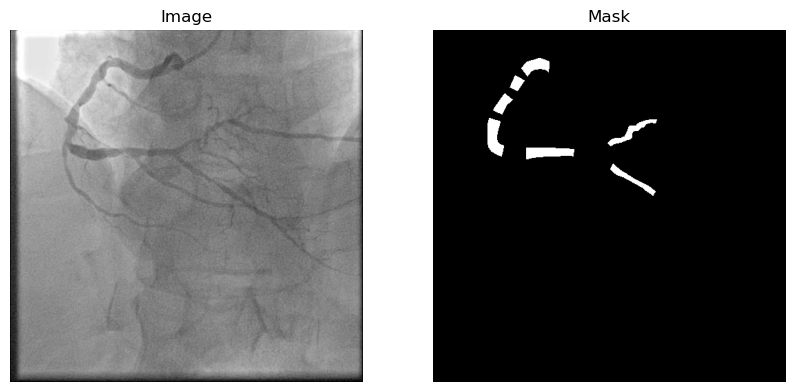

In [246]:
visualize_image_and_mask(image, mask)

In [49]:
image.size()

torch.Size([512, 512, 3])

In [213]:
import torch 
import torch.nn.functional as F
from torchvision.transforms.functional import to_pil_image


def plot_mask_and_image(image, mask):
    image = np.array(image, dtype = np.uint8).transpose(2,0,1)
    mask = np.array(mask).reshape(1,512, 512)

    image = torch.from_numpy(image).type(torch.uint8)
    mask = torch.from_numpy(mask).type(torch.bool)

    drawn = draw_segmentation_masks(image, mask, alpha = 0.7, colors = (0, 255, 0))

    drawn = to_pil_image(drawn).resize(size = (256, 256))
    
    return drawn

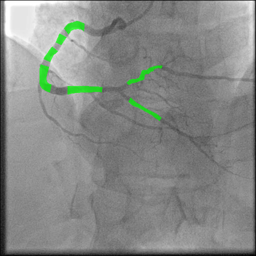

In [247]:
drawn = plot_mask_and_image(image, mask)
drawn

In [137]:
import matplotlib.pyplot as plt

def plot_images_in_row(images):
    """
    Plot multiple images in a row using Matplotlib.
    
    Args:
        images (list of numpy arrays): List of images to plot.
    """
    num_images = len(images)
    fig, axes = plt.subplots(1, num_images, figsize=(4*num_images, 4))
    
    for i in range(num_images):
        axes[i].imshow(images[i])
        axes[i].axis('off')
        
    plt.tight_layout()
    plt.savefig("../data/interim/visualization.jpg", bbox_inches='tight')
    plt.show()


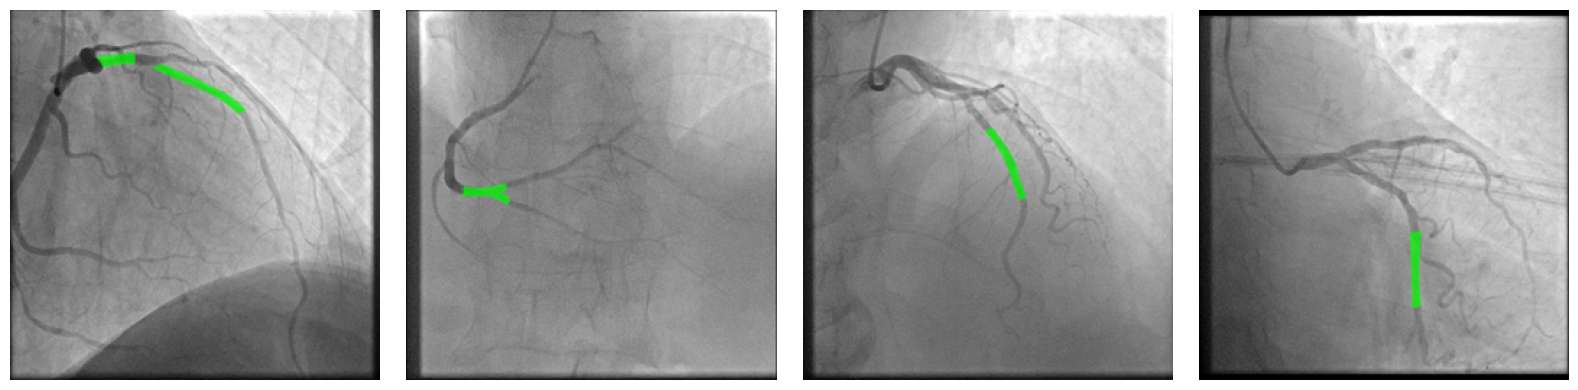

In [138]:
images = []
for ids in [540, 560, 561, 562]:
    
    image = Image.open(f"../data/processed/train/images/{ids}.png")
    mask = Image.open(f"../data/processed/train/masks/{ids}.png")
    
    drawn = plot_mask_and_image(image, mask)
    
    images.append(drawn)

    
plot_images_in_row(images)
